# Linear regression with various methods
This is a very simple example of using two scipy tools for linear regression.
* Scipy.Polyfit
* Stats.linregress
* Optimize.curve_fit
* numpy.linalg.lstsq
* statsmodels.OLS
* Analytic solution using Moore-Penrose generalized inverse or simple multiplicative matrix inverse
* sklearn.linear_model.LinearRegression

## Import libraries

In [116]:
from scipy import linspace, polyval, polyfit, sqrt, stats, randn, optimize
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd

%matplotlib inline

## Generate random data of a sufficiently large size

In [117]:
def gen_data_lin(a, b, n):
    x=np.random.uniform(-10,10,n)
    #parameters
    y = polyval([a,b],x) + 3 * randn(n)
    return x, y

In [118]:
#Sample data creation
def gen_data_normal(a, b, n):
    np.random.seed(42)
    scale_ratio = 5
    x0 = np.random.normal(loc=40, scale=5.5, size=n)
    y0 = np.random.normal(loc=0, scale=2.0, size=n)

    # rotate dataset + stretch it
    # so the fit should be a line of slope a and offset b
    #     angle = np.arctan(a) # this doesn't work well for high slopes, so pass the angle directly
    Mrot = [[np.cos(a), -np.sin(a)],
            [np.sin(a), np.cos(a)]]
    [x, y] = np.matmul(Mrot, np.array([x0, y0]).T.reshape(n, 2, 1)).T.reshape(2, -1)

    # add offset
    y = y + b
    return x, y

In [119]:
# pick the data shape
gen_data = gen_data_normal
# gen_data = gen_data_gauss

#number of points 
n=int(3e7)

# slope (for the normal distribution data, a is the angle, and the slope is tan(a))
# a = 0.577350269189626 # 30deg
# a = 1.732050807568877 # 60deg
# a = 1 # 45 deg
# a = 10 # 3.25
a = 0.523598775598299 # 30deg
# a = 3.25

fa = lambda x: x

if gen_data.__class__ == gen_data_normal.__class__:
    print('a = %.3f' % np.tan(a))
    fa = lambda x: np.tan(x)

# offset
b = -6.5

x, y = gen_data(a, b, n)
# x, y = gen_data(a, b, n)
# x values to draw the ideal fit line
xline = np.linspace(x.min(), x.max(), n)

a = 0.577


### Draw few random sample points and plot

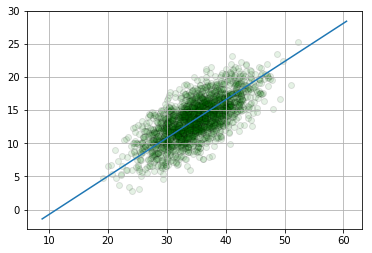

In [120]:
xvar=x[:2000]
yvar=y[:2000]

plt.scatter(xvar,yvar,c='green',edgecolors='k', alpha=0.1)
plt.plot(xline, fa(a) * xline + b, alpha=1.0)
plt.grid(True)
plt.axis(option='square')
# plt.xlim((-20, 100))
# plt.ylim((-20, 100))
plt.show()

## Method: Scipy.Polyfit

In [121]:
def scipy_polyfit(x, y, prt=True):
    #Linear regressison -polyfit - polyfit can be used other orders polynomials
    t = time.time()
    (ar, br) = polyfit(x, y, 1)
    dt = time.time() - t
    if prt:
        # this is extra computation to check validity
        xr = polyval([ar, br], xline)
        # compute the mean square error
        err=sqrt(sum((xr - x)**2)/len(x))
        print('Linear regression using polyfit')
        print('parameters: a=%.2f b=%.2f, ms error= %.3f' % (ar, br, err))
        print("Time taken: {} seconds".format(dt))
    return dt

In [122]:
scipy_polyfit(x, y)

Linear regression using polyfit
parameters: a=0.48 b=-3.12, ms error= 22.831
Time taken: 3.0730013847351074 seconds


3.0730013847351074

In [123]:
# time the polyfit part
t_scipy_polyfit = %timeit -o scipy_polyfit(x, y, prt=False)
t_scipy_polyfit_avg = t_scipy_polyfit.average
t_scipy_polyfit_std = t_scipy_polyfit.stdev

2.96 s ± 47.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Method: Stats.linregress

In [124]:
def stats_linregress(x, y, prt=True):
    #Linear regression using stats.linregress
    t = time.time()
    (a_s, b_s, r, tt, stderr)=stats.linregress(x,y)
    dt = time.time() -t
    if prt:
        print('Linear regression using stats.linregress')
        print('a=%.2f b=%.2f, std error= %.3f, r^2 coefficient= %.3f' % (a_s, b_s, stderr, r))
        print("Time taken: {} seconds".format(dt))
    return dt

In [125]:
stats_linregress(x, y)

Linear regression using stats.linregress
a=0.48 b=-3.12, std error= 0.000, r^2 coefficient= 0.719
Time taken: 0.669304370880127 seconds


0.669304370880127

In [126]:
t_linregress = %timeit -o stats_linregress(x, y, prt=False)
t_linregress_avg = t_linregress.average
t_linregress_std = t_linregress.stdev

681 ms ± 4.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Method: Optimize.curve_fit

In [127]:
def flin(x, a, b):
    return a * x + b

In [128]:
def optimize_curve_fit(x, y, prt=True):
    t = time.time()
    p1, _ = optimize.curve_fit(flin, xdata=x, ydata=y, method='lm')
    dt = time.time() - t
    if prt:
        print('Linear regression using optimize.curve_fit')
        print('parameters: a=%.2f b=%.2f' % (p1[0], p1[1]))
        print("Time taken: {} seconds".format(dt))
    return dt

In [129]:
optimize_curve_fit(x, y)

Linear regression using optimize.curve_fit
parameters: a=0.48 b=-3.12
Time taken: 5.4208948612213135 seconds


5.4208948612213135

In [130]:
t_optimize_curve_fit = %timeit -o optimize_curve_fit(x, y, prt=False)
t_optimize_curve_fit_avg = t_optimize_curve_fit.average
t_optimize_curve_fit_std = t_optimize_curve_fit.stdev

5.4 s ± 40.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Method: numpy.linalg.lstsq

In [131]:
def linalg_lstsq(x, y, prt=True):
    t = time.time()
    A = np.vstack([x, np.ones(len(y))]).T
    result = np.linalg.lstsq(A, y)
    ar, br = result[0]
    err = np.sqrt(result[1]/len(y))
    dt = time.time() - t 
    if prt:
        print('Linear regression using numpy.linalg.lstsq')
        print('parameters: a=%.2f b=%.2f, ms error= %.3f' % (ar,br,err))
        print("Time taken: {} seconds".format(dt))
    return dt

In [132]:
linalg_lstsq(x, y)

Linear regression using numpy.linalg.lstsq
parameters: a=0.48 b=-3.12, ms error= 2.260
Time taken: 1.7844781875610352 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


1.7844781875610352

In [133]:
t_linalg_lstsq = %timeit -o linalg_lstsq(x, y, prt=False)
t_linalg_lstsq_avg = t_linalg_lstsq.average
t_linalg_lstsq_std = t_linalg_lstsq.stdev

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


1.73 s ± 35.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Method: Statsmodels.OLS

In [134]:
def statsmodel_ols(x, y, prt=True):
    t = time.time()
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
    ar = results.params[1]
    br = results.params[0]
    dt = time.time() - t
    if prt: 
        print('Linear regression using statsmodels.OLS')
        print('parameters: a=%.2f b=%.2f'% (ar,br))
        print("Time taken: {} seconds".format(dt)) 
        print(results.summary())
    return dt

In [135]:
statsmodel_ols(x, y)

Linear regression using statsmodels.OLS
parameters: a=0.48 b=-3.12
Time taken: 3.9574990272521973 seconds
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                 3.206e+07
Date:                Wed, 09 Jan 2019   Prob (F-statistic):               0.00
Time:                        22:59:58   Log-Likelihood:            -6.7028e+07
No. Observations:            30000000   AIC:                         1.341e+08
Df Residuals:                29999998   BIC:                         1.341e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

3.9574990272521973

In [136]:
t_OLS = %timeit -o statsmodel_ols(x, y, prt=False)
t_OLS_avg = t_OLS.average
t_OLS_std = t_OLS.stdev

3.95 s ± 52.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Analytic solution using Moore-Penrose pseudoinverse

In [137]:
def moore_penrose(x, y, prt=True):
    t=time.time()
    X = sm.add_constant(x)
    mpinv = np.linalg.pinv(X)
    result = mpinv.dot(y)
    ar = result[1]
    br = result[0]
    dt = time.time() - t
    if prt:
        print('Linear regression using Moore-Penrose inverse')
        print('parameters: a=%.2f b=%.2f'% (ar, br))
        print("Time taken: {} seconds".format(dt)) 
    return dt

In [138]:
moore_penrose(x, y)

Linear regression using Moore-Penrose inverse
parameters: a=0.48 b=-3.12
Time taken: 2.6197924613952637 seconds


2.6197924613952637

In [139]:
t_inv_matrix = %timeit -o moore_penrose(x, y, prt=False)
t_inv_matrix_avg = t_inv_matrix.average
t_inv_matrix_std = t_inv_matrix.stdev

2.6 s ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Analytic solution using simple multiplicative matrix inverse

In [140]:
def simple_matrix_inverse(x, y, prt=True):
    t = time.time()
    X = sm.add_constant(x)
    m = np.dot((np.dot(np.linalg.inv(np.dot(X.T, X)), X.T)), y)
    ar = m[1]
    br = m[0]
    dt = time.time() - t
    if prt:
        print('Linear regression using simple inverse')
        print('parameters: a=%.2f b=%.2f'% (ar, br))
        print("Time taken: {} seconds".format(dt)) 
    return dt

In [141]:
simple_matrix_inverse(x, y)

Linear regression using simple inverse
parameters: a=0.48 b=-3.12
Time taken: 0.9870486259460449 seconds


0.9870486259460449

In [142]:
t_simple_inv = %timeit -o simple_matrix_inverse(x, y, prt=False)
t_simple_inv_avg = t_simple_inv.average
t_simple_inv_std = t_simple_inv.stdev

1.01 s ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Method: sklearn.linear_model.LinearRegression

In [143]:
def sklearn_linear_regression(x, y, prt=True):
    t = time.time()
    lm = LinearRegression()
    X = sm.add_constant(x)
    lm.fit(X, y)
    ar = lm.coef_[1]
    br = lm.intercept_
    dt = time.time() - t
    
    if prt:
        print('Linear regression using sklearn.linear_model.LinearRegression')
        print('parameters: a=%.2f b=%.2f'% (ar,br))
        print("Time taken: {} seconds".format(dt)) 
    return dt

In [144]:
sklearn_linear_regression(x, y)

Linear regression using sklearn.linear_model.LinearRegression
parameters: a=0.48 b=-3.12
Time taken: 3.146655321121216 seconds


3.146655321121216

In [145]:
t_sklearn_linear = %timeit -o sklearn_linear_regression(x, y, prt=False)
t_sklearn_linear_avg = t_sklearn_linear.average
t_sklearn_linear_std = t_sklearn_linear.stdev

3.12 s ± 23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Method: pytorch matrix inverse

In [146]:
import torch
import torch.nn as nn


In [147]:
print(torch.cuda.is_available())

True


In [148]:
torch.cuda.device_count()

2

In [149]:
torch.__version__

'1.0.0'

In [150]:
cuda = torch.device('cuda:0')

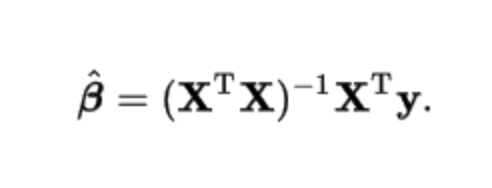

In [151]:
def pytorch_matrix_inverse_cuda(x, y, prt=True):
    t = time.time()
    n = x.shape[0]
    x1 = np.append(np.ones((n, 1)), x.reshape((n, 1)), 1)
    tx = torch.tensor(x1, device=cuda)
    ty = torch.tensor(y.reshape((n, 1)), device=cuda)
    m = ((tx.transpose(0, 1).mm(tx)).inverse()).mm(tx.transpose(0 , 1).mm(ty))
    dt = time.time() - t
    if prt:
        print(m)
        print('GPU compute %f' % dt)
    return dt

In [152]:
def pytorch_matrix_inverse_cpu(x, y, prt=True):
    t = time.time()
    n = x.shape[0]
    x1 = np.append(np.ones((n, 1)), x.reshape((n, 1)), 1)
    tx = torch.from_numpy(x1)
    ty = torch.from_numpy(y.reshape((n, 1)))
    m = ((tx.transpose(0, 1).mm(tx)).inverse()).mm(tx.transpose(0 , 1).mm(ty))
    dt = time.time() - t
    if prt:
        print(m)
        print('GPU compute %f' % dt)
    return dt

In [153]:
pytorch_matrix_inverse_cpu(x, y)

tensor([[-3.1247],
        [ 0.4799]], dtype=torch.float64)
GPU compute 0.576988


0.5769882202148438

In [162]:
t_torch_cpu = %timeit -o pytorch_matrix_inverse_cpu(x, y, prt=False)
t_torch_cpu_avg = t_torch_cpu.average
t_torch_cpu_std = t_torch_cpu.stdev

504 ms ± 4.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [155]:
pytorch_matrix_inverse_cuda(x, y)

tensor([[-3.1247],
        [ 0.4799]], device='cuda:0', dtype=torch.float64)
GPU compute 0.739484


0.7394838333129883

In [163]:
t_torch_cuda = %timeit -o pytorch_matrix_inverse_cuda(x, y, prt=False)
t_torch_cuda_avg = t_torch_cuda.average
t_torch_cuda_std = t_torch_cuda.stdev

688 ms ± 20 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Bucket all the execution times in a list and plot

In [165]:
times = [
    t_scipy_polyfit_avg,
    t_linregress_avg,
    t_optimize_curve_fit_avg,
    t_linalg_lstsq_avg,
    t_OLS_avg,
    t_inv_matrix_avg,
    t_simple_inv_avg,
    t_sklearn_linear_avg,
    t_torch_cpu_avg,
    t_torch_cuda_avg
]
err = [
    t_scipy_polyfit_std,
    t_linregress_std,
    t_optimize_curve_fit_std,
    t_linalg_lstsq_std,
    t_OLS_std,
    t_inv_matrix_std,
    t_simple_inv_std,
    t_sklearn_linear_std,
    t_torch_cpu_std,
    t_torch_cuda_std
]

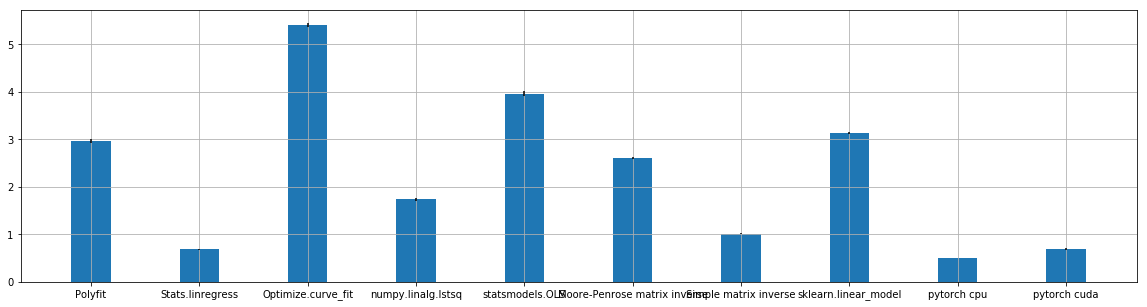

In [166]:
plt.figure(figsize=(20,5))
plt.grid(True)
plt.bar(x=[l*1.1 for l in range(10)],
        height=times, 
        width=0.4,
        yerr=err,
        tick_label=[
            'Polyfit',
            'Stats.linregress',
            'Optimize.curve_fit',
            'numpy.linalg.lstsq',
            'statsmodels.OLS',
            'Moore-Penrose matrix inverse',
            'Simple matrix inverse',
            'sklearn.linear_model',
            'pytorch cpu',
            'pytorch cuda'
        ])
plt.show()

In [167]:
n_min = 50000
n_max = int(1e7)
n_levels = 25
r = np.log10(n_max/n_min)
l = np.linspace(0,r,n_levels)
n_data = list((n_min*np.power(10,l)))
n_data = [int(n) for n in n_data]

In [168]:
methods = {
    'Polyfit': scipy_polyfit,
    'Stats.linregress': stats_linregress,
    'Optimize.curve_fit': optimize_curve_fit,
    'linalg.lstsq': linalg_lstsq, 
    'statsmodels.OLS': statsmodel_ols,
    'Moore-Penrose matrix inverse': moore_penrose,
    'Simple matrix inverse': simple_matrix_inverse,
    'sklearn.linear_model': sklearn_linear_regression,
    'pytorch cpu': pytorch_matrix_inverse_cpu,
    'pytorch cuda': pytorch_matrix_inverse_cuda
}
l1 = methods.keys()
time_dict = {key:[] for key in l1}

from tqdm import tqdm

for i in tqdm(range(len(n_data))):
    n = n_data[i]
    x, y = gen_data_lin(a, b, n)
    for method in methods:
#         dt = %timeit -o methods[method](x, y, prt=False)
#         time_dict[method].append(dt.average*1e3)
        dt = methods[method](x, y, prt=False)
        time_dict[method].append(dt*1e3)


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the inp

 80%|████████  | 20/25 [00:12<00:08,  1.77s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.
 84%|████████▍ | 21/25 [00:15<00:08,  2.20s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.
 88%|████████▊ | 22/25 [00:19<00:08,  2.83s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` 

In [169]:
df = pd.DataFrame(data=time_dict)
df

,Polyfit,Stats.linregress,Optimize.curve_fit,linalg.lstsq,statsmodels.OLS,Moore-Penrose matrix inverse,Simple matrix inverse,sklearn.linear_model,pytorch cpu,pytorch cuda
0,7.165670,1.179218,7.600069,1.865387,6.159306,2.479553,0.967503,5.000830,0.705957,10.706425
1,5.499363,1.093864,8.721590,2.184153,6.637812,3.141642,1.146317,5.752325,0.635862,4.463434
2,6.237507,1.123667,10.596514,2.663612,8.604527,4.462004,1.628160,9.721279,0.954151,5.851269
3,9.632111,1.792431,14.093876,4.193306,13.320684,5.446434,2.002239,11.785746,1.169443,6.295204
4,12.016535,2.127886,17.337322,4.664898,13.608694,6.000757,2.205133,12.483358,9.874582,7.909775
5,12.654305,2.296925,18.564224,5.553484,17.471313,7.497311,2.756357,15.383959,10.304451,8.178711
6,16.217232,2.896547,23.288965,6.844521,16.461849,9.401560,3.632784,19.232273,10.751486,9.570837
7,19.690037,3.562927,28.048038,6.691933,19.387960,11.479378,4.550219,24.834156,11.257887,9.364367
8,24.709702,4.394531,31.559706,8.393526,25.135040,14.611959,5.569220,29.951572,11.874914,7.910490
9,28.311968,4.201889,38.845062,10.488033,30.000210,18.215656,7.235527,37.798643,3.944397,8.800745


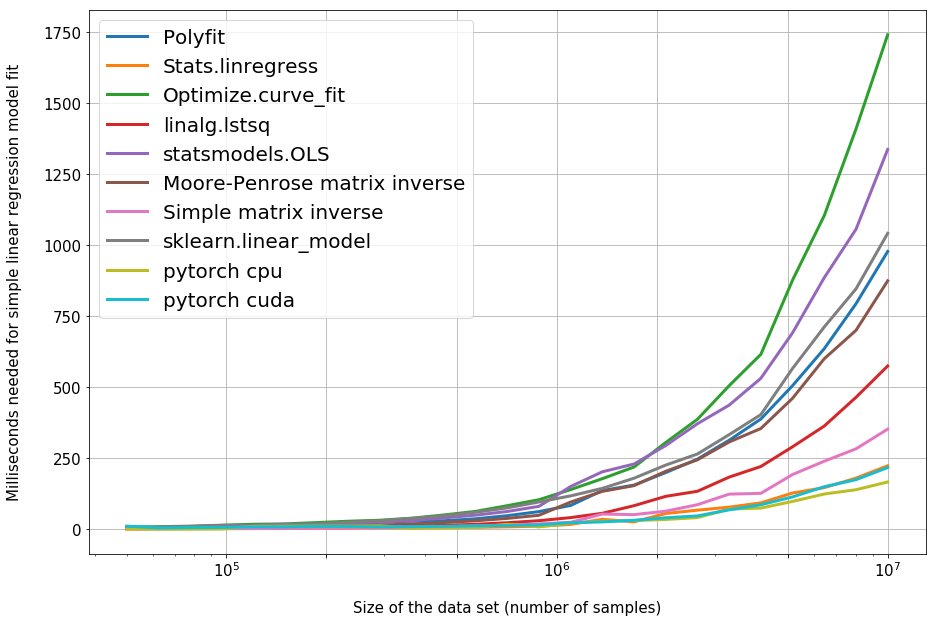

In [170]:
plt.figure(figsize=(15,10))
for i in df.columns:
    plt.semilogx((n_data),df[i],lw=3)
plt.xticks([1e5,2e5,5e5,1e6,2e6,5e6,1e7],fontsize=15)
plt.xlabel("\nSize of the data set (number of samples)",fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Milliseconds needed for simple linear regression model fit\n",fontsize=15)
plt.grid(True)
plt.legend([name for name in df.columns],fontsize=20)

In [171]:
a1=df.iloc[n_levels-1].sort_values()

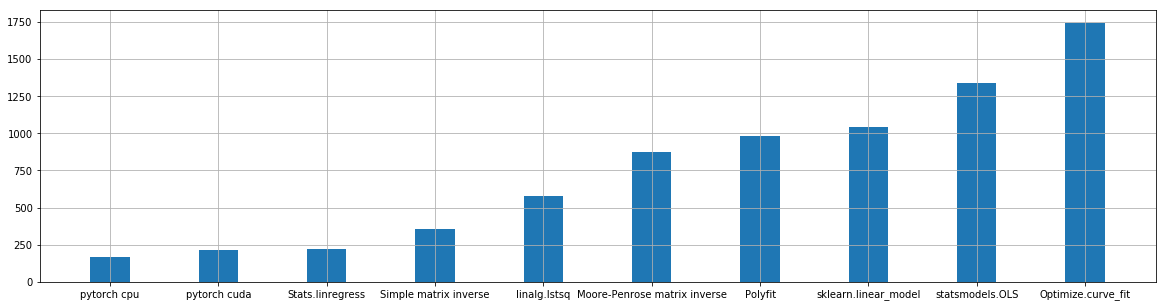

In [173]:
plt.figure(figsize=(20,5))
plt.grid(True)
plt.bar(x=[l*1.1 for l in range(10)],height=a1, width=0.4,
        tick_label=list(a1.index))
plt.show()

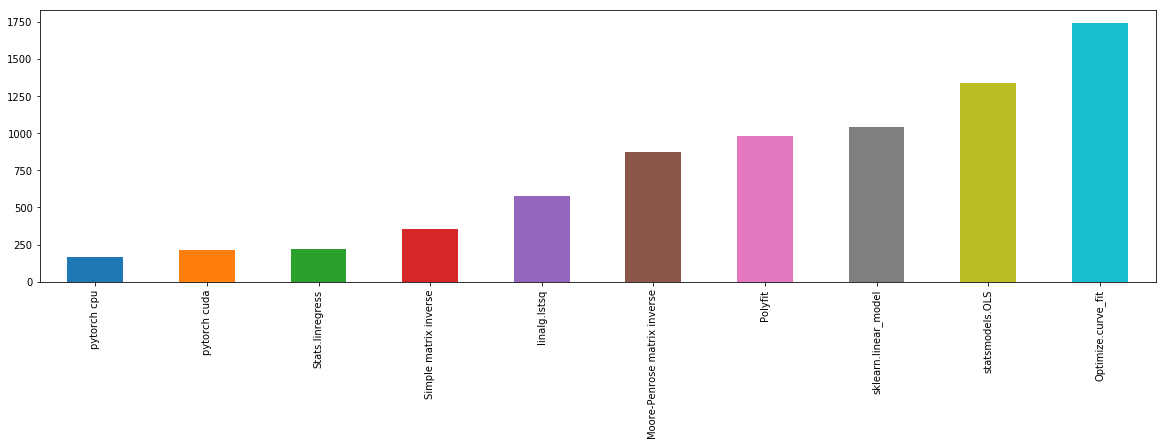

In [174]:
df.iloc[n_levels-1].sort_values().plot.bar(figsize=(20,5))